In [1]:
# Setup for notebook

# Setup for pd, sns and plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Setup for BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account

In [2]:
# Setup for BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account

# Specify the filename of your service account key (make sure it's in the same folder as your notebook)
key_path = '/home/hanafi/ntu-sctp-dsai1f-project-team6/Citibike_Analysis/forward-garden-461903-m9-863379912db1.json'

# Confirm the file exists (optional check)
import os
print("Key exists:", os.path.exists(key_path))  # Should return True

# Create credentials and BigQuery client
credentials = service_account.Credentials.from_service_account_file(key_path)
client = bigquery.Client(credentials=credentials, project='forward-garden-461903-m9')

Key exists: True


/home/hanafi/miniconda3/envs/dsai_project/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


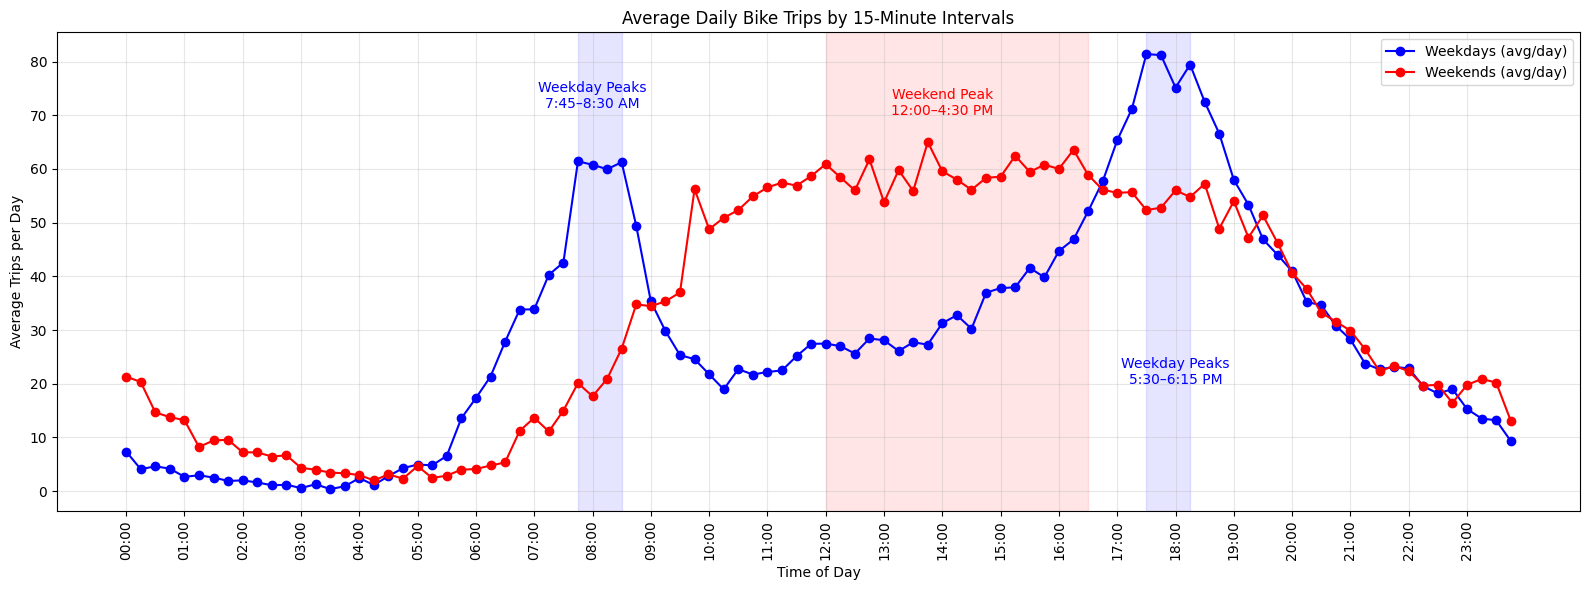

In [4]:
query = """
    SELECT
      DATE(started_at) AS date,
      CONCAT(
        LPAD(CAST(EXTRACT(HOUR FROM started_at) AS STRING), 2, '0'), ':',
        LPAD(CAST(FLOOR(EXTRACT(MINUTE FROM started_at)/15)*15 AS STRING), 2, '0')
      ) AS time_of_day,
      CASE
        WHEN EXTRACT(DAYOFWEEK FROM started_at) IN (1, 7) THEN 'weekend'
        ELSE 'weekday'
      END AS day_type
    FROM `forward-garden-461903-m9.citibike.fact_trips`
    WHERE started_at >= DATE_SUB(CURRENT_TIMESTAMP(), INTERVAL 50 DAY)
"""
trip_trend_df = client.query(query).to_dataframe()

# 1. Count trips per time slot per day
trip_counts = trip_trend_df.groupby(['date', 'time_of_day', 'day_type']).size().reset_index(name='trip_count')
# print(trip_counts)

# 2. Count number of unique days for each day_type
day_counts = trip_trend_df.groupby('day_type')['date'].nunique().reset_index(name='total_days')
# print(day_counts)

# 3. Calculate average trips per day
result = (
    trip_counts.groupby(['time_of_day', 'day_type'])['trip_count']
    .sum()
    .reset_index()
    .merge(day_counts, on='day_type')
)

result['avg_trips_per_day'] = result['trip_count'] / result['total_days']

# print(result)

# Pivot for plotting
pivot_df = result.pivot(index='time_of_day', columns='day_type', values='avg_trips_per_day')

# print(pivot_df)

# Define peak ranges (based on observed data)
weekday_peaks = [('07:45', '08:30'), ('17:30', '18:15')]
weekend_peaks = [('12:00', '16:30')]

# Convert to index positions for shading
def get_range_indices(start, end, index):
    return index.get_loc(start), index.get_loc(end)


# Visualization
plt.figure(figsize=(16, 6))
plt.plot(
    pivot_df.index,
    pivot_df['weekday'],
    marker='o',
    linestyle='-',
    color='blue',
    label='Weekdays (avg/day)'
)
plt.plot(
    pivot_df.index,
    pivot_df['weekend'],
    marker='o',
    linestyle='-',
    color='red',
    label='Weekends (avg/day)'
)

plt.title('Average Daily Bike Trips by 15-Minute Intervals')
plt.xlabel('Time of Day')
plt.ylabel('Average Trips per Day')
# plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.legend()


# Shade weekday peaks
for start, end in weekday_peaks:
    i1, i2 = get_range_indices(start, end, pivot_df.index)
    plt.axvspan(i1, i2, color='blue', alpha=0.1)

# Shade weekend peaks
for start, end in weekend_peaks:
    i1, i2 = get_range_indices(start, end, pivot_df.index)
    plt.axvspan(i1, i2, color='red', alpha=0.1)

# Annotations
plt.text(pivot_df.index.get_loc('08:00'), pivot_df['weekday'].max() - 10,
         'Weekday Peaks\n7:45–8:30 AM',
         fontsize=10, color='blue', ha='center')

plt.text(pivot_df.index.get_loc('18:00'), 20,
         'Weekday Peaks\n5:30–6:15 PM',
         fontsize=10, color='blue', ha='center')

plt.text(pivot_df.index.get_loc('14:00'), pivot_df['weekend'].max() + 5,
         'Weekend Peak\n12:00–4:30 PM',
         fontsize=10, color='red', ha='center')

# Only show full hour labels on x-axis
hour_ticks = [t for t in pivot_df.index if t.endswith(':00')]
plt.xticks(ticks=[pivot_df.index.get_loc(t) for t in hour_ticks], labels=hour_ticks, rotation=90)




plt.tight_layout()
plt.show()

Key Findings:

```Python
Based on the chart “Average Daily Bike Trips by 15-Minute Intervals”, here are the key findings — including usage behavior and revenue implications:

1. Weekday Morning Peak (7:45–8:30 AM)

   - Observation: Sharp rise in trips; highest volume around 8:00 AM

   - Likely Cause: Commuters heading to work or school

   - Revenue Implication:

     If trips exceed free/minimum ride time (e.g., 30 min), potential overage fees apply
     High trip volume → significant cumulative revenue even from small surcharges
     Mostly member users, so lower per-trip revenue but higher overall retention and volume

2. Weekday Evening Peak (5:30–6:15 PM)

   - Observation: Second strong surge in trips after work hours

   - Likely Cause: Work-to-home commutes, short errands

   - Revenue Implication:
     Similar to morning: short trips may trigger fees if late
     Some users may switch to casual plans or Lyft integration → higher per-trip revenue

3.  Weekend Midday Peak (12:00–4:30 PM)

    - Observation: Broad and steady high activity range

    - Likely Cause: Leisure rides, sightseeing, recreational trips

    - Revenue Implication:
      Riders more likely to be non-members (casuals or tourists)
      Longer durations → overage charges or day pass purchases
      Higher per-trip revenue compared to weekdays
      Opportunity for premium pricing on high-demand weekends

| Time Window             | Rider Type Likely          | Trip Type          | Revenue Source                            | Revenue Potential         |
| ----------------------- | -------------------------- | ------------------ | ----------------------------------------- | ------------------------- |
| 7:45–8:30 AM (Weekday)  | Members (commuters)        | Short rides        | Membership fees, overage surcharges       | Medium (volume-driven)    |
| 5:30–6:15 PM (Weekday)  | Mixed (commuters + casual) | Short–mid rides    | Membership + casual rates                 | Medium–High               |
| 12:00–4:30 PM (Weekend) | Casual/Tourist             | Long leisure rides | Day passes, time extensions, casual fares | **High (price per trip)** |


```Python
Suggestions:

Offer discounts or loyalty perks for weekday commuter periods to increase retention.

Promote family/group day passes during weekend peaks.

Consider dynamic pricing to optimize revenue during weekend surges.
```